This notebook tries to reproduce the simulation described in an awesome blogpost by Google Analytics team:

https://analytics.googleblog.com/2013/01/multi-armed-bandit-experiments.html


In [119]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')


Assuming that we are running an A/B test for a web design, the control group has a baseline CTR 0.04, and the exposed group is supposed to have a CTR 0.05.

Question: what's the required number of visitors in order to declare a statistically significant results? 

One can use a standard power calculation to figure out the required number of observations.

In [81]:
group_means = [0.04, 0.05]
group_stds = [np.sqrt(p*(1.0-p)) for p in group_means]


In [62]:
def calculatePower(group_means, group_stds, n_per_group, n_simulations=1000):
    
    n_groups = len(group_means)
    data = np.zeros((n_simulations, n_per_group, n_groups))
    for i in range(n_groups):
        dist_generator = scipy.stats.norm(loc=group_means[i], scale=group_stds[i])
        data[:, :, i] = dist_generator.rvs(size=(n_simulations, n_per_group))
        
    result = scipy.stats.ttest_ind(data[:, :, 0], data[:, :, 1], axis=1)
    return np.mean(result[1] < 0.05)


In [84]:
list_of_sizes = []
list_of_powers = []

size = 1000
power = calculatePower(group_means, group_stds, size)

list_of_sizes.append(size)
list_of_powers.append(power)
while power < 0.95:
    size += 1000
    power = calculatePower(group_means, group_stds, size)
    list_of_sizes.append(size)
    list_of_powers.append(power)

size: 2000, power: 0.3
size: 3000, power: 0.424
size: 4000, power: 0.578
size: 5000, power: 0.655
size: 6000, power: 0.754
size: 7000, power: 0.812
size: 8000, power: 0.866
size: 9000, power: 0.911
size: 10000, power: 0.935
size: 11000, power: 0.955


In [83]:
pd.DataFrame({'size': list_of_sizes, 'power': list_of_powers})[['size', 'power']]

,size,power
0,1000,0.201
1,2000,0.337
2,3000,0.444
3,4000,0.577
4,5000,0.673
5,6000,0.734
6,7000,0.823
7,8000,0.867
8,9000,0.893
9,10000,0.927


A standard power calculation as illustrated above shows that we need at least 11000 observations per arm in order to have 95% statistical power. 

This accounts to 22000 total observations. Assuming 100 visitos per day, we will need 220 days to run the experiment.


In [130]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

Next, we use multi-armed bandit setup to run the experiment.

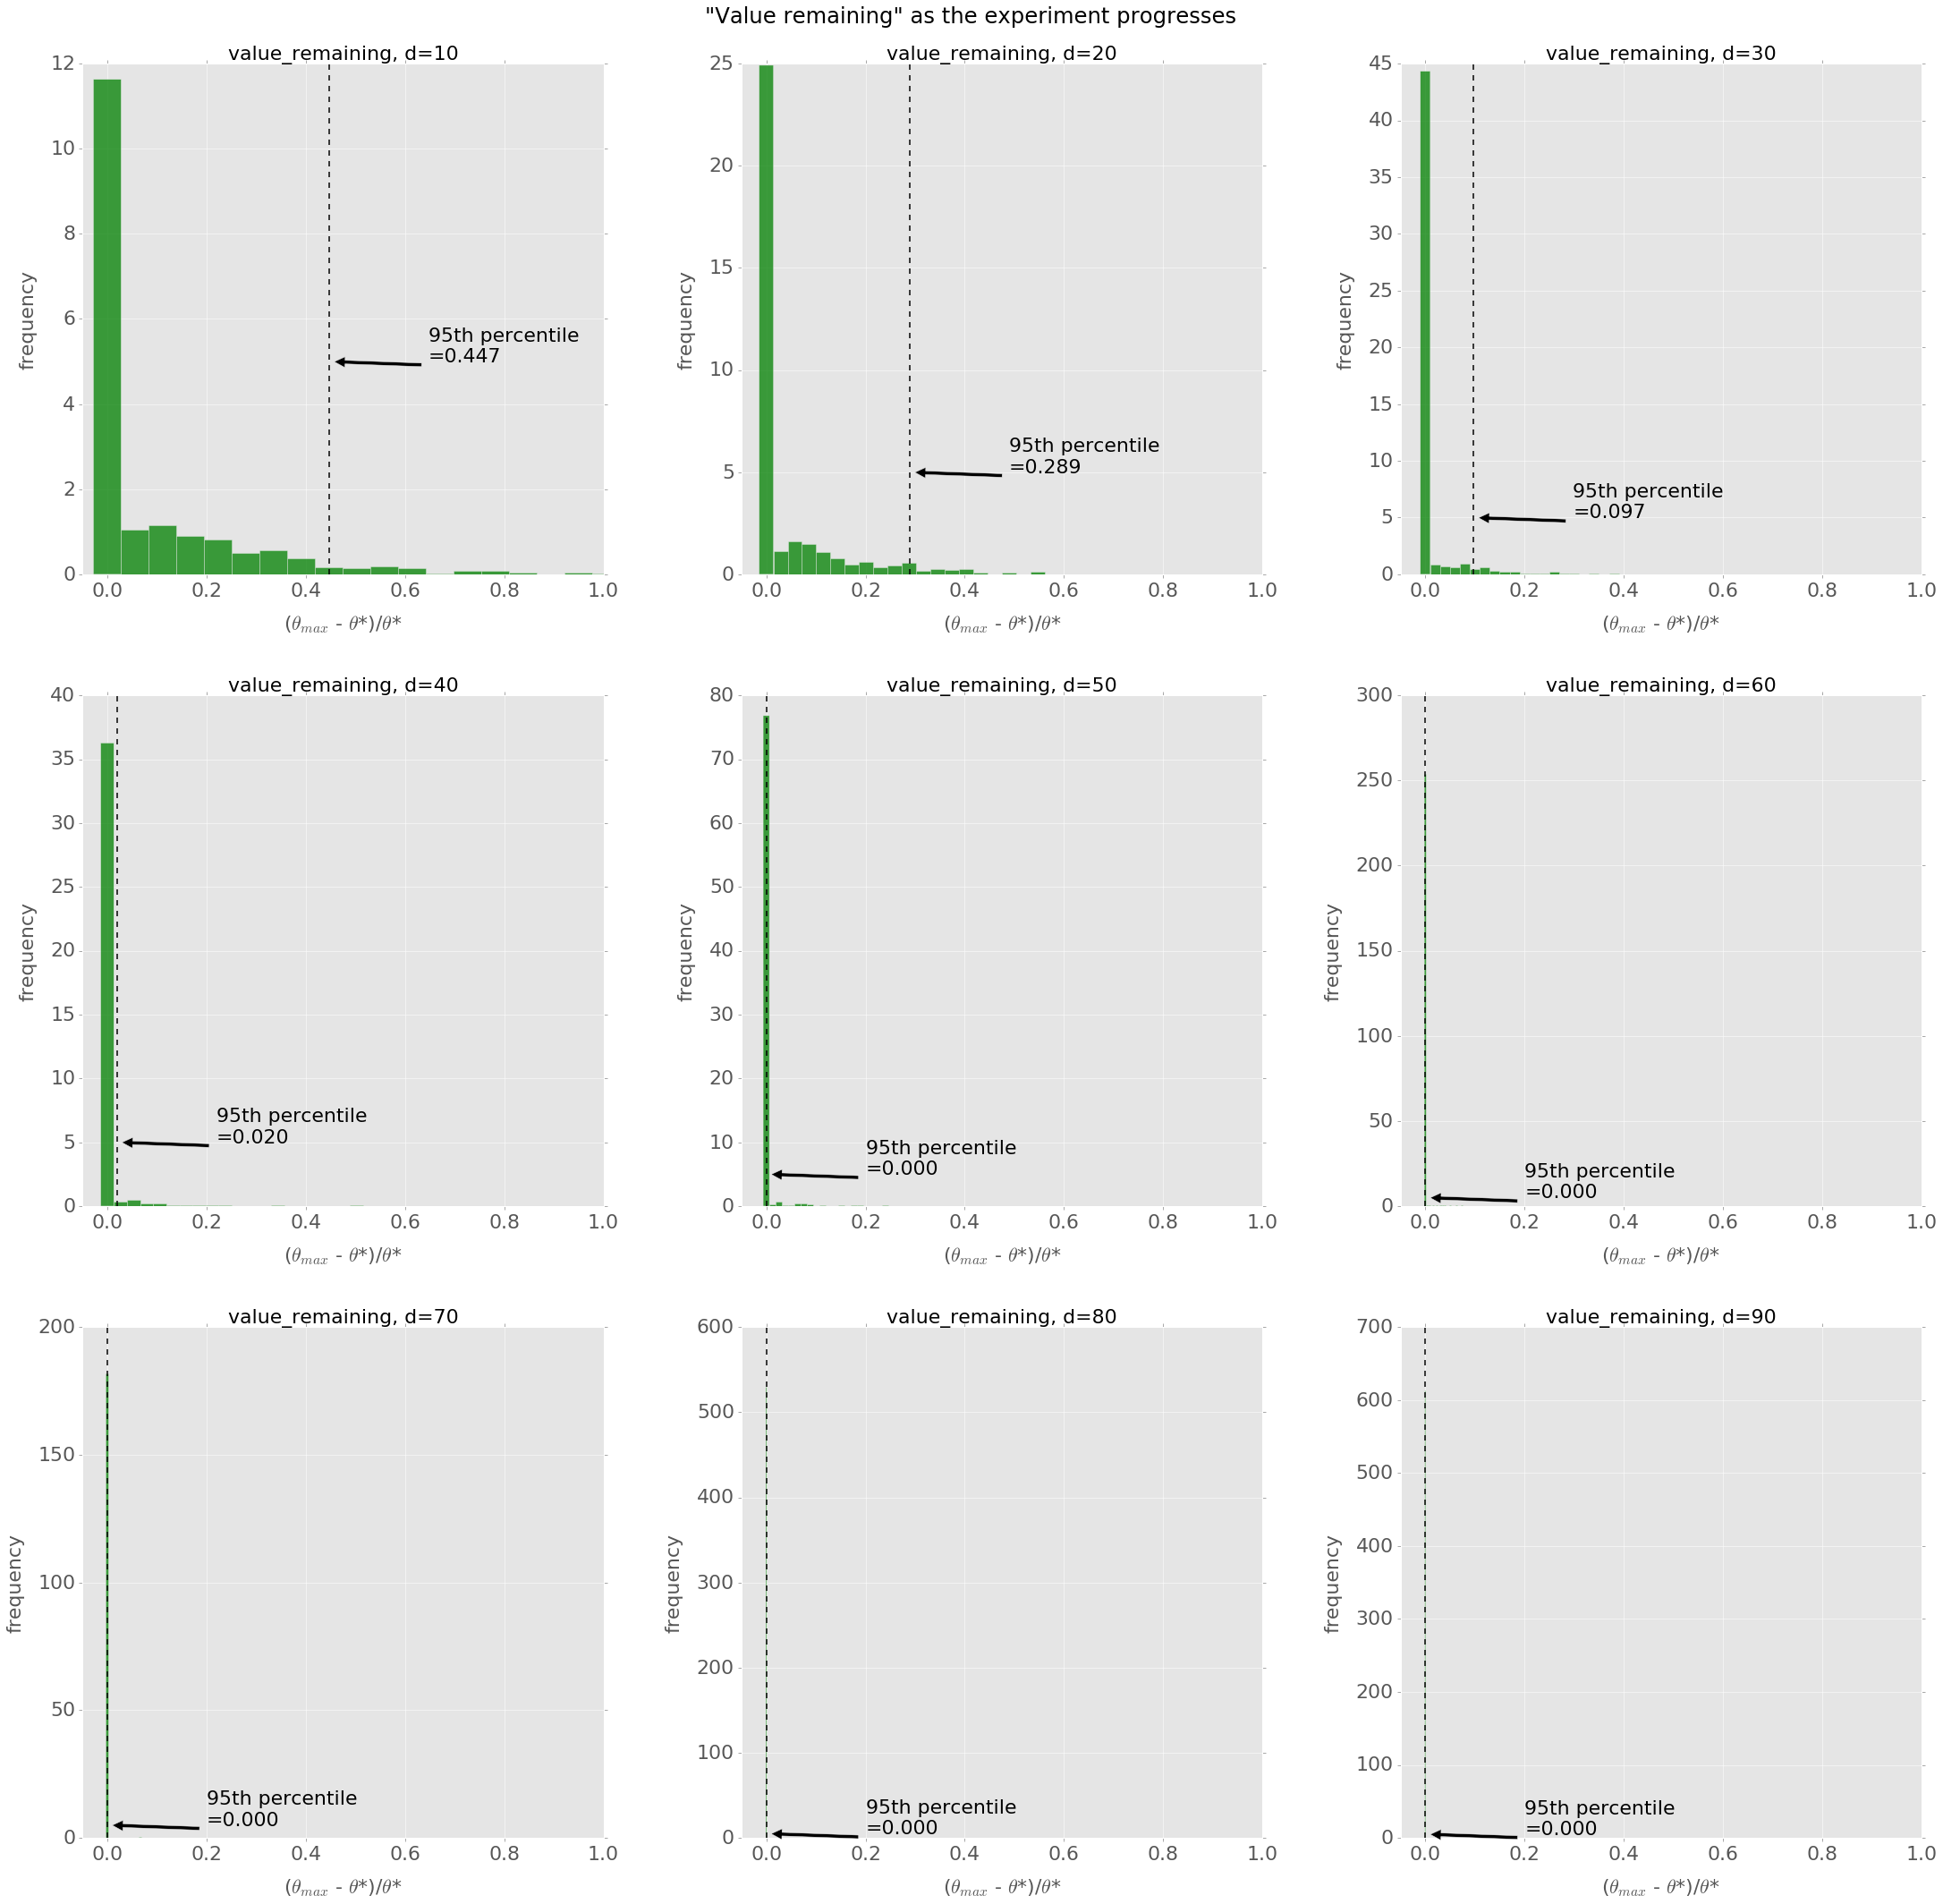

In [221]:
pseudo_n_c = 100  # c = control
pseudo_x_c = 4
pseudo_n_e = 100  # e = exposed 
pseudo_x_e = 5

baseline = float(pseudo_x_c)/float(pseudo_n_c)

n_visitos_per_day = 100
n_days = 100
data = np.zeros((n_days, 4))  # n_c, x_c, n_e, x_e

n_plotted = 0
fig = plt.figure(figsize=(30, 30))
gs = matplotlib.gridspec.GridSpec(3, 3)
for d in range(n_days):
    if d == 0:
        n_c = n_visitos_per_day // 2
        x_c = int(0.15 * pseudo_n_c)
        n_e = n_visitos_per_day - n_c
        x_e = int(0.05 * pseudo_n_e)
    else:
        # Ues Beta-Binomial to calculate the posterior distribution
        # And then use the posterior to calculate the probability of doing better than baseline
        #  (the tail probability) 
        # Use the tail probabilities as weights to assgin visits
        weights = np.zeros(2)
        
        a = pseudo_x_c + np.sum(data[0:d, 1])
        b = (pseudo_n_c + np.sum(data[0:d, 0])) - a
        arm0 = float(a)/float(a+b)
        arm0_generator =scipy.stats.beta(a=a, b=b)        
        prob_c = 1.0 - scipy.stats.beta(a=a, b=b).cdf(baseline)
        
        a = pseudo_x_e + np.sum(data[0:d, 3])
        b = (pseudo_n_e + np.sum(data[0:d, 2])) - a
        arm1 = float(a)/float(a+b)
        arm1_generator = scipy.stats.beta(a=a, b=b)
        prob_e = 1.0 - scipy.stats.beta(a=a, b=b).cdf(baseline)
        
        
        if d % 10 == 0 and n_plotted < 9:
            iv = n_plotted // 3
            ih = n_plotted % 3
            ax = plt.subplot(gs[iv, ih])
            
            optimal_arm, suboptimal_arm = (0, 1) if arm0 > arm1 else (1, 0)
            arm0_values = arm0_generator.rvs(size=1000)
            arm1_values = arm1_generator.rvs(size=1000)                    
            df = pd.DataFrame({'arm0': arm0_values, 'arm1': arm1_values})[['arm0', 'arm1']]
            df['value_remaining'] = (df.iloc[:, suboptimal_arm] - df.iloc[:, optimal_arm])/df.iloc[:, optimal_arm]
            df['value_remaining'] = df['value_remaining'].apply(lambda x: x if x > 0 else 0)        
                
            percentile_95th = np.percentile(df['value_remaining'].values, 95)    
                
            FONTSIZE = 22
            #plt.close('all')
            #fig, ax = plt.subplots(1, figsize=(10, 7))
            n, bins, patches = ax.hist(df['value_remaining'], 20, normed=1, facecolor='green', alpha=0.75, align='left')
            ax.axvline(x=percentile_95th, linewidth=1.5, linestyle='--', color='k')
            ax.set_title('value_remaining, d={0:}'.format(d), fontsize=FONTSIZE)
            ax.set_xlabel(r'($\theta_{max}$ - $\theta$*)/$\theta$*', fontsize=FONTSIZE, labelpad=15)
            ax.set_ylabel('frequency', fontsize=FONTSIZE, labelpad=15)
            ax.set_xlim(-0.05, 1.0)
            adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)        

            
            ax.annotate('95th percentile\n={0:.3f}'.format(percentile_95th),
                         xy=(percentile_95th, 5), 
                         xytext=(percentile_95th+0.2, 5), 
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=FONTSIZE)
            
            #file_name = 'value_remaining_d{0:}.png'.format(str(d).zfill(4))
            #plt.savefig(file_name, bbox_inches='tight')
            n_plotted += 1
        
        weights = [prob_c, prob_e]
        weights = np.array(weights)/np.sum(weights)
        
        n_c = np.sum(np.random.random(size=n_visitos_per_day) < weights[0])
        n_e = n_visitos_per_day - n_c
                
        # simulate the number of positives in each group
        x_c = int( n_c * scipy.stats.beta(a=pseudo_x_c, b=pseudo_n_c-pseudo_x_c).rvs() )
        x_e = int( n_e * scipy.stats.beta(a=pseudo_x_e, b=pseudo_n_e-pseudo_x_e).rvs() )
    
    # store the result 
    data[d, :] = np.array([n_c, x_c, n_e, x_e])
        #data[d, 0] = n_c; data[d, 1] = x_c; data[d, 2] = n_e; data[d, 3] = x_e
        
plt.tight_layout(pad=0, w_pad=5.0, h_pad=5.0)
fig.suptitle('"Value remaining" as the experiment progresses', fontsize=1.1*FONTSIZE)
plt.subplots_adjust(top=0.95)


As the above plots show, after running the experiment for 50 days, the "value remaining" is essentially zero. Meaning that we have chosen a clear winner arm. 

Below also shows the number of days required to have a 95% confidence, which is consistesnt with the conclusion drawn about the value remaining.


In [222]:
data_df = pd.DataFrame(data)
data_df.columns = ['n_c', 'x_c', 'n_e', 'x_e'] 
control = data_df['x_c'].cumsum() / data_df['n_c'].cumsum()
exposed = data_df['x_e'].cumsum() / data_df['n_e'].cumsum()

In [223]:
required_days = data_df[data_df['n_e'] > 95].head(1).index.tolist()[0]
required_visits = int(np.sum(data[0:required_days+1, 0]) + np.sum(data[0:required_days+1, 2]))
print('required days to find a winner arm: {0:}'.format(required_days))
print('required number of visits: {0:}'.format(required_visits))


required days to find a winner arm: 46
required number of visits: 4700


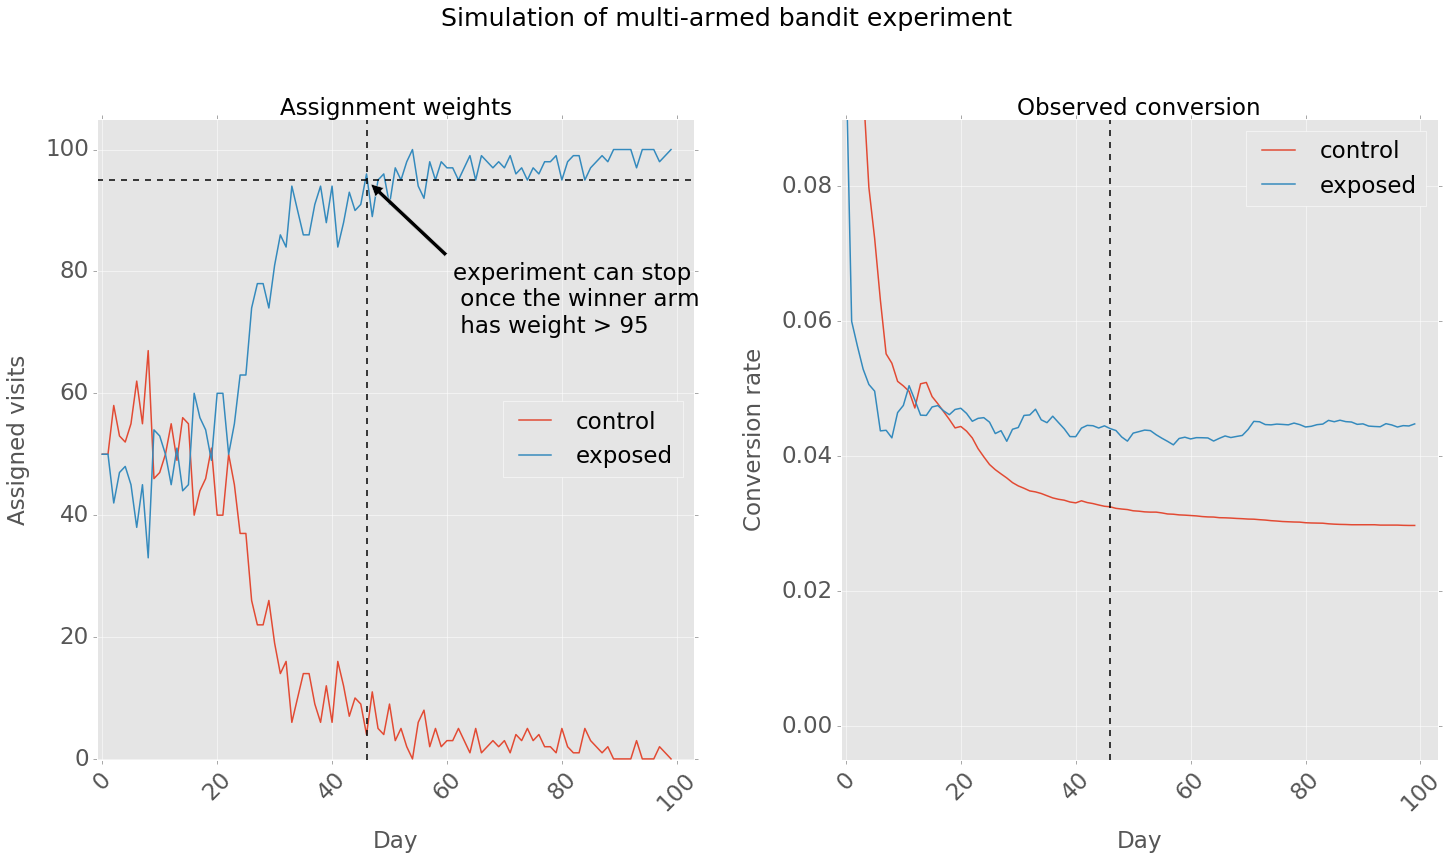

In [224]:
FONTSIZE = 23
plt.close('all')
fig = plt.figure(figsize=(20, 12))
gs = matplotlib.gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
ax.plot(np.arange(n_days), data[:, 0], linestyle='-', linewidth=1.5, label='control')
ax.plot(np.arange(n_days), data[:, 2], linestyle='-', linewidth=1.5, label='exposed')
ax.axhline(y=95, linewidth=1.5, linestyle='--', color='k')
ax.axvline(x=required_days, linewidth=1.5, linestyle='--', color='k')
ax.annotate('experiment can stop\n once the winner arm\n has weight > 95', 
            xy=(required_days, 95), xytext=(required_days+15, 95-25), 
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=FONTSIZE)

ax.set_xlim(-0.9, n_days+3)
ax.set_ylim(-0.1, 105)
ax.set_xlabel("Day", fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel("Assigned visits", fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 45, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE)
ax.set_title('Assignment weights', fontsize=FONTSIZE)

ax = plt.subplot(gs[0, 1])
ax.plot(np.arange(n_days), control, linestyle='-', linewidth=1.5, label='control')
ax.plot(np.arange(n_days), exposed, linestyle='-', linewidth=1.5, label='exposed')
ax.set_xlim(-0.9, n_days+3)
ax.set_ylim(-0.005, 0.09)
ax.set_xlabel("Day", fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel("Conversion rate", fontsize=FONTSIZE, labelpad=15)
ax.axvline(x=required_days, linewidth=1.5, linestyle='--', color='k')
adjustAxeProperties(ax, FONTSIZE, 45, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE)
ax.set_title('Observed conversion', fontsize=FONTSIZE)


plt.tight_layout(pad=0, w_pad=4.0, h_pad=0)
fig.suptitle('Simulation of multi-armed bandit experiment', fontsize=1.1*FONTSIZE)
plt.subplots_adjust(top=0.85)
